## Edited: This file uses the edited image_edited.py library instead of the original image.py library.

In [1]:
## Edited: This file uses the edited image_edited.py library instead of the original image.py library.
from __future__ import print_function
import sys
# if len(sys.argv) != 4:
#     print('Usage:')
#     print('python train.py datacfg cfgfile weightfile')
#     exit()

import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torchvision import datasets, transforms
from torch.autograd import Variable

import dataset
import random
import math
import os
from utils import *
from cfg import parse_cfg
from region_loss import RegionLoss
from darknet import Darknet
from models.tiny_yolo import TinyYoloNet

from livelossplot import PlotLosses

In [2]:
# Training settings
datacfg       = 'cfg/hands.data'
cfgfile       = 'cfg/yolo-single-object.cfg'
weightfile    = 'darknet19_448.conv.23'

# datacfg       = sys.argv[1]
# cfgfile       = sys.argv[2]
# weightfile    = sys.argv[3]

data_options  = read_data_cfg(datacfg)
net_options   = parse_cfg(cfgfile)[0]

trainlist     = data_options['train']
testlist      = data_options['valid']
backupdir     = data_options['backup']
nsamples      = file_lines(trainlist)
gpus          = data_options['gpus']  # e.g. 0,1,2,3
ngpus         = len(gpus.split(','))
num_workers   = int(data_options['num_workers'])

batch_size    = int(net_options['batch'])
max_batches   = int(net_options['max_batches'])
learning_rate = float(net_options['learning_rate'])
momentum      = float(net_options['momentum'])
decay         = float(net_options['decay'])
steps         = [float(step) for step in net_options['steps'].split(',')]
scales        = [float(scale) for scale in net_options['scales'].split(',')]

#Train parameters
max_epochs    = max_batches*batch_size/nsamples+1
use_cuda      = True
seed          = int(time.time())
eps           = 1e-5
save_interval = 10  # epoches
dot_interval  = 70  # batches

# Test parameters
conf_thresh   = 0.25
nms_thresh    = 0.4
iou_thresh    = 0.5

if not os.path.exists(backupdir):
    os.mkdir(backupdir)
 

In [3]:
###############
torch.manual_seed(seed)
if use_cuda:
    os.environ['CUDA_VISIBLE_DEVICES'] = gpus
    torch.cuda.manual_seed(seed)

model       = Darknet(cfgfile)
region_loss = model.loss

model.load_weights(weightfile)
model.print_network()

region_loss.seen  = model.seen
processed_batches = model.seen/batch_size

init_width        = model.width
init_height       = model.height
init_epoch        = model.seen/nsamples 

kwargs = {'num_workers': num_workers, 'pin_memory': True} if use_cuda else {}
test_loader = torch.utils.data.DataLoader(
    dataset.listDataset(testlist, shape=(init_width, init_height),
                   shuffle=False,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                   ]), train=False),
    batch_size=batch_size, shuffle=False, **kwargs)

if use_cuda:
    if ngpus > 1:
        model = torch.nn.DataParallel(model).cuda()
    else:
        model = model.cuda()

params_dict = dict(model.named_parameters())
params = []
for key, value in params_dict.items():
    if key.find('.bn') >= 0 or key.find('.bias') >= 0:
        params += [{'params': [value], 'weight_decay': 0.0}]
    else:
        params += [{'params': [value], 'weight_decay': decay*batch_size}]
optimizer = optim.SGD(model.parameters(), lr=learning_rate/batch_size, momentum=momentum, dampening=0, weight_decay=decay*batch_size)

cfg.py:182: UserWarning: src is not broadcastable to dst, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  conv_model.weight.data.copy_(torch.from_numpy(buf[start:start+num_w])); start = start + num_w


layer     filters    size              input                output
    0 conv     32  3 x 3 / 1   416 x 416 x   3   ->   416 x 416 x  32
    1 max          2 x 2 / 2   416 x 416 x  32   ->   208 x 208 x  32
    2 conv     64  3 x 3 / 1   208 x 208 x  32   ->   208 x 208 x  64
    3 max          2 x 2 / 2   208 x 208 x  64   ->   104 x 104 x  64
    4 conv    128  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x 128
    5 conv     64  1 x 1 / 1   104 x 104 x 128   ->   104 x 104 x  64
    6 conv    128  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x 128
    7 max          2 x 2 / 2   104 x 104 x 128   ->    52 x  52 x 128
    8 conv    256  3 x 3 / 1    52 x  52 x 128   ->    52 x  52 x 256
    9 conv    128  1 x 1 / 1    52 x  52 x 256   ->    52 x  52 x 128
   10 conv    256  3 x 3 / 1    52 x  52 x 128   ->    52 x  52 x 256
   11 max          2 x 2 / 2    52 x  52 x 256   ->    26 x  26 x 256
   12 conv    512  3 x 3 / 1    26 x  26 x 256   ->    26 x  26 x 512
   13 conv    256  1 x 

In [4]:
def adjust_learning_rate(optimizer, batch):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    lr = learning_rate
    for i in range(len(steps)):
        scale = scales[i] if i < len(scales) else 1
        if batch >= steps[i]:
            lr = lr * scale
            if batch == steps[i]:
                break
        else:
            break
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr/batch_size
    return lr

def train(epoch):
    global processed_batches
    running_loss = 0.0

    t0 = time.time()
    if ngpus > 1:
        cur_model = model.module
    else:
        cur_model = model
    train_loader = torch.utils.data.DataLoader(
        dataset.listDataset(trainlist, shape=(init_width, init_height),
                       shuffle=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                       ]), 
                       train=True, 
                       seen=cur_model.seen,
                       batch_size=batch_size,
                       num_workers=num_workers),
        batch_size=batch_size, shuffle=False, **kwargs)

    lr = adjust_learning_rate(optimizer, processed_batches)
    logging('epoch %d, processed %d samples, lr %f' % (epoch, epoch * len(train_loader.dataset), lr))
    model.train()
    t1 = time.time()
    avg_time = torch.zeros(9)
    for batch_idx, (data, target) in enumerate(train_loader):
        t2 = time.time()
        adjust_learning_rate(optimizer, processed_batches)
        processed_batches = processed_batches + 1
        #if (batch_idx+1) % dot_interval == 0:
        #    sys.stdout.write('.')

        if use_cuda:
            data = data.cuda()
            #target= target.cuda()
        t3 = time.time()
        data, target = Variable(data), Variable(target)
        t4 = time.time()
        optimizer.zero_grad()
        t5 = time.time()
        output = model(data)
        t6 = time.time()
        region_loss.seen = region_loss.seen + data.data.size(0)
        loss = region_loss(output, target)
        t7 = time.time()
        loss.backward()
        t8 = time.time()
        optimizer.step()
        t9 = time.time()
        if False and batch_idx > 1:
            avg_time[0] = avg_time[0] + (t2-t1)
            avg_time[1] = avg_time[1] + (t3-t2)
            avg_time[2] = avg_time[2] + (t4-t3)
            avg_time[3] = avg_time[3] + (t5-t4)
            avg_time[4] = avg_time[4] + (t6-t5)
            avg_time[5] = avg_time[5] + (t7-t6)
            avg_time[6] = avg_time[6] + (t8-t7)
            avg_time[7] = avg_time[7] + (t9-t8)
            avg_time[8] = avg_time[8] + (t9-t1)
            print('-------------------------------')
            print('       load data : %f' % (avg_time[0]/(batch_idx)))
            print('     cpu to cuda : %f' % (avg_time[1]/(batch_idx)))
            print('cuda to variable : %f' % (avg_time[2]/(batch_idx)))
            print('       zero_grad : %f' % (avg_time[3]/(batch_idx)))
            print(' forward feature : %f' % (avg_time[4]/(batch_idx)))
            print('    forward loss : %f' % (avg_time[5]/(batch_idx)))
            print('        backward : %f' % (avg_time[6]/(batch_idx)))
            print('            step : %f' % (avg_time[7]/(batch_idx)))
            print('           total : %f' % (avg_time[8]/(batch_idx)))
        t1 = time.time()

        # For "livelossplot"
        running_loss += loss

    # For "livelossplot"
    prefix = ''
    epoch_loss = running_loss / int(len(train_loader.dataset)/batch_size)
    logs[prefix + 'Loss'] = epoch_loss.data[0]

    print('')
    t1 = time.time()
    logging('training with %f samples/s' % (len(train_loader.dataset)/(t1-t0)))

    if (epoch+1) % save_interval == 0:
        logging('save weights to %s/%06d.weights' % (backupdir, epoch+1))
        cur_model.seen = (epoch + 1) * len(train_loader.dataset)
        cur_model.save_weights('%s/%06d.weights' % (backupdir, epoch+1))

def test(epoch):
    def truths_length(truths):
        for i in range(50):
            if truths[i][1] == 0:
                return i

    model.eval()
    if ngpus > 1:
        cur_model = model.module
    else:
        cur_model = model
    num_classes = cur_model.num_classes
    anchors     = cur_model.anchors
    num_anchors = cur_model.num_anchors
    total       = 0.0
    proposals   = 0.0
    correct     = 0.0

    running_loss = 0.0

    for batch_idx, (data, target) in enumerate(test_loader):
        if use_cuda:
            data = data.cuda()
        data = Variable(data, volatile=True)
        output = model(data)

        # For "livelossplot"
        target = Variable(target, volatile=True)
        loss = region_loss(output, target)
        running_loss += loss
        output = output.data
        target = target.data

        all_boxes = get_region_boxes(output, conf_thresh, num_classes, anchors, num_anchors)
        for i in range(output.size(0)):
            boxes = all_boxes[i]
            boxes = nms(boxes, nms_thresh)

            truths = target[i].view(-1, 5)
            num_gts = truths_length(truths)
     
            total = total + num_gts
    
            for i in range(len(boxes)):
                if boxes[i][4] > conf_thresh:
                    proposals = proposals+1

            for i in range(num_gts):
                box_gt = [truths[i][1], truths[i][2], truths[i][3], truths[i][4], 1.0, 1.0, truths[i][0]]
                best_iou = 0
                best_j = -1
                for j in range(len(boxes)):
                    iou = bbox_iou(box_gt, boxes[j], x1y1x2y2=False)
                    if iou > best_iou:
                        best_j = j
                        best_iou = iou
                if best_iou > iou_thresh and boxes[best_j][6] == box_gt[6]:
                    correct = correct+1

    # For "livelossplot"
    prefix = 'val_'
    epoch_loss = running_loss / int(len(test_loader.dataset)/batch_size)
    logs[prefix + 'Loss'] = epoch_loss.data[0]

    precision = 1.0*correct/(proposals+eps)
    recall = 1.0*correct/(total+eps)
    fscore = 2.0*precision*recall/(precision+recall+eps)
    logging("precision: %f, recall: %f, fscore: %f" % (precision, recall, fscore))

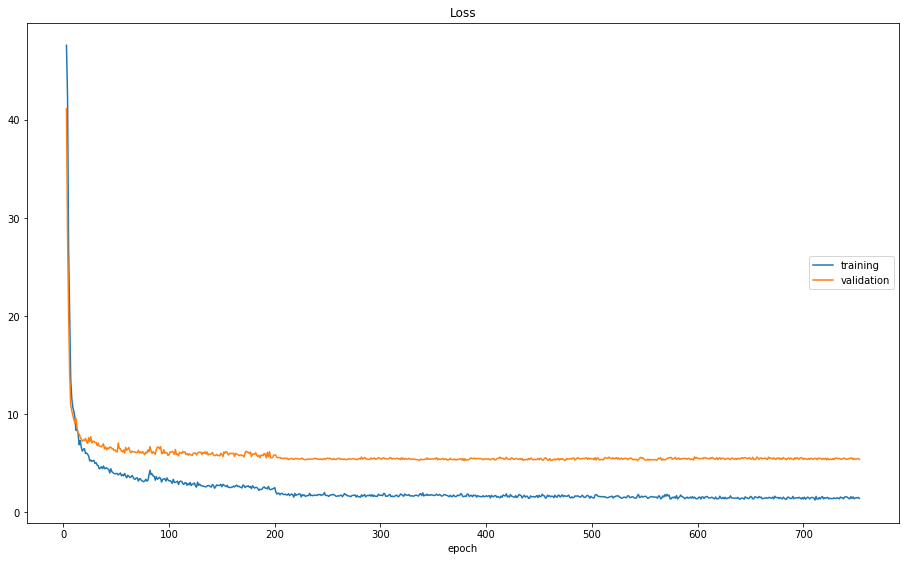

Loss:
training   (min:    1.220, max:  398.494, cur:    1.388)
validation (min:    5.238, max:   63.052, cur:    5.374)

Training...
2019-07-11 16:51:45 epoch 753, processed 2409600 samples, lr 0.000010
2409632: nGT 64, recall 64, proposals 166, loss: x 0.103196, y 0.102595, w 0.054493, h 0.159304, conf 0.756767, cls 0.000000, total 1.176355
2409664: nGT 64, recall 64, proposals 150, loss: x 0.058059, y 0.090377, w 0.043391, h 0.064185, conf 0.268018, cls 0.000000, total 0.524031
2409696: nGT 64, recall 64, proposals 233, loss: x 0.162949, y 0.253325, w 0.134602, h 0.154412, conf 0.641349, cls 0.000000, total 1.346636
2409728: nGT 64, recall 64, proposals 157, loss: x 0.195503, y 0.144519, w 0.086669, h 0.248317, conf 0.734966, cls 0.000000, total 1.409974
2409760: nGT 64, recall 64, proposals 192, loss: x 0.259897, y 0.097382, w 0.098686, h 0.074857, conf 0.528760, cls 0.000000, total 1.059582
2409792: nGT 64, recall 64, proposals 163, loss: x 0.135045, y 0.130596, w 0.055642, h 0.145

2411456: nGT 64, recall 64, proposals 158, loss: x 0.151463, y 0.063139, w 0.073659, h 0.129101, conf 0.478362, cls 0.000000, total 0.895725
2411488: nGT 64, recall 63, proposals 151, loss: x 0.284924, y 0.168104, w 0.116243, h 0.268972, conf 1.815466, cls 0.000000, total 2.653709
2411520: nGT 64, recall 64, proposals 143, loss: x 0.114055, y 0.066448, w 0.258749, h 0.137268, conf 1.119352, cls 0.000000, total 1.695872
2411552: nGT 64, recall 64, proposals 193, loss: x 0.080591, y 0.069012, w 0.056609, h 0.137841, conf 0.302843, cls 0.000000, total 0.646895
2411584: nGT 64, recall 64, proposals 248, loss: x 0.194922, y 0.187132, w 0.069157, h 0.076584, conf 1.145718, cls 0.000000, total 1.673512
2411616: nGT 64, recall 64, proposals 152, loss: x 0.107683, y 0.060020, w 0.099076, h 0.088244, conf 0.882469, cls 0.000000, total 1.237493
2411648: nGT 64, recall 64, proposals 165, loss: x 0.184407, y 0.108139, w 0.091671, h 0.121315, conf 0.478507, cls 0.000000, total 0.984040
2411680: nGT 

In [ ]:
liveloss = PlotLosses()
evaluate = False
if evaluate:
    logging('evaluating ...')
    test(0)
else:
    for epoch in range(init_epoch, max_epochs):
        logs = {}
        
        print('Training...')
        train(epoch)
        print('Evaluating...')
        test(epoch)
        
        print('')
        liveloss.update(logs)
        liveloss.draw()
        print('')